In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [6]:
# 1. 파일 경로 설정
DATA_PATH = '../data'
train_path = os.path.join(DATA_PATH, 'train.csv')
sub_path = os.path.join(DATA_PATH, 'sample_submission.csv')

# 2. 데이터 로드
print(">>> 데이터 로딩 중...")
train = pd.read_csv(train_path)
submission = pd.read_csv(sub_path)

print(f"Train data shape: {train.shape}")
print(f"Submission data shape: {submission.shape}")
print("-" * 50)

# 3. 데이터 구조 확인 (컬럼명 확인이 중요합니다)
print(">>> Train 데이터 상위 5개 행:")
print(train.head())
print("\n>>> Train 데이터 컬럼 정보:")
print(train.columns.tolist())
print("-" * 50)

# -------------------------------------------------------------------------
# [중요] 타겟 컬럼(무역량) 자동 식별 시도
# 이미지에는 잘려있었지만, 보통 'value', 'amount', 'price' 등이 타겟입니다.
# year, month, seq, type, item_id를 제외한 나머지 숫자 컬럼을 찾습니다.
# -------------------------------------------------------------------------
exclude_cols = ['item_id', 'year', 'month', 'seq', 'type', 'ID', 'hs4', 'weight', 'quantity', 'value']
numeric_cols = train.select_dtypes(include=['number']).columns
target_col = [c for c in numeric_cols if c not in exclude_cols]

if len(target_col) == 1:
    target_col = target_col[0]
    print(f"\n>>> 예측 대상 컬럼(Target)으로 추정되는 컬럼: '{target_col}'")
else:
    print(f"\n>>> [주의] 타겟 컬럼을 명확히 찾지 못했습니다. 후보: {target_col}")
    # 만약 자동으로 못 찾으면 아래에 직접 입력해야 합니다.
    # target_col = 'value' 

print("-" * 50)

# 4. 월별 집계 (Aggregation)
# 원본은 seq(일련번호)가 있어 같은 달에도 여러 건이 있을 수 있습니다.
# 이를 [item_id, year, month] 기준으로 묶어서 합(sum)을 구해야 합니다.

if isinstance(target_col, str): # 타겟 컬럼이 확인된 경우만 실행
    print(">>> 월별 데이터 집계(Group By) 진행 중...")
    
    # 월별 총 무역량 합계 구하기
    train_agg = train.groupby(['item_id', 'year', 'month'])[target_col].sum().reset_index()
    
    # 시계열 분석을 위한 'date' 컬럼 생성 (YYYY-MM-01 형태)
    train_agg['date'] = pd.to_datetime(train_agg['year'].astype(str) + '-' + 
                                       train_agg['month'].astype(str) + '-01')
    
    # 데이터 확인
    print("\n>>> 월별 집계 완료 데이터 (train_agg):")
    print(train_agg.head())
    
    # 5. 피벗 테이블 생성 (행: 시간, 열: 아이템, 값: 무역량)
    # 공행성 분석을 위해 Wide Form으로 변환
    pivot_df = train_agg.pivot(index='date', columns='item_id', values=target_col)
    pivot_df = pivot_df.fillna(0) # 거래 없는 달은 0으로 처리
    
    print("\n>>> 피벗 테이블 형태 (행: 시간, 열: 아이템):")
    print(pivot_df.iloc[:5, :5]) # 5행 5열만 출력

>>> 데이터 로딩 중...
Train data shape: (10836, 9)
Submission data shape: (9900, 3)
--------------------------------------------------
>>> Train 데이터 상위 5개 행:
    item_id  year  month  seq  type   hs4    weight  quantity     value
0  DEWLVASR  2022      1  1.0     1  3038   14858.0       0.0   32688.0
1  ELQGMQWE  2022      1  1.0     1  2002   62195.0       0.0  110617.0
2  AHMDUILJ  2022      1  1.0     1  2102   18426.0       0.0   72766.0
3  XIPPENFQ  2022      1  1.0     1  2501   20426.0       0.0   11172.0
4  FTSVTTSR  2022      1  1.0     1  2529  248000.0       0.0  143004.0

>>> Train 데이터 컬럼 정보:
['item_id', 'year', 'month', 'seq', 'type', 'hs4', 'weight', 'quantity', 'value']
--------------------------------------------------

>>> [주의] 타겟 컬럼을 명확히 찾지 못했습니다. 후보: []
--------------------------------------------------


In [ ]:
# 1. 데이터 로드 및 전처리 (월별 집계)
# -------------------------------------------------------------------------------
DATA_PATH = '../data'
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))

# 날짜 컬럼 생성 (YYYY-MM-01)
train['date'] = pd.to_datetime(train['year'].astype(str) + '-' + 
                               train['month'].astype(str) + '-01')

# [핵심] 'item_id'와 'date' 기준으로 'value' 합계 구하기
# seq가 달라도 같은 달이면 합쳐야 월별 추이를 볼 수 있습니다.
df_agg = train.groupby(['date', 'item_id'])['value'].sum().reset_index()

# Pivot Table 생성 (행: 날짜, 열: 아이템, 값: value)
# 결측치(NaN)는 거래가 없는 것이므로 0으로 채움
pivot_df = df_agg.pivot(index='date', columns='item_id', values='value').fillna(0)

print(f">>> 분석 대상 품목 수: {len(pivot_df.columns)}개")
print(f">>> 분석 기간: {pivot_df.index.min()} ~ {pivot_df.index.max()}")

>>> 분석 대상 품목 수: 100개
>>> 분석 기간: 2022-01-01 00:00:00 ~ 2025-07-01 00:00:00
--------------------------------------------------


>>> 상관계수 계산 중... (잠시만 기다려주세요)

>>> 발견된 공행성 쌍 개수: 24개 (Threshold=0.6)
   Leader (선행) Follower (후행)  Correlation
17    RJCAXSGH      KFQSHBNH     0.942943
5     FTSVTTSR      RUVXNNVA     0.930682
9     NAQIHUKZ      FTSVTTSR     0.896119
18    RUVXNNVA      LLHREMKS     0.886308
7     KFQSHBNH      RJCAXSGH     0.847961
15    QSDCUCLB      XIIEJNEE     0.784995
11    QRKRBYJL      QVLMOEYE     0.781671
1     ATLDMDBO      QRKRBYJL     0.726702
2     BLANHGYY      FDXPMYGF     0.712631
22    VBYCLTYZ      QVLMOEYE     0.698124


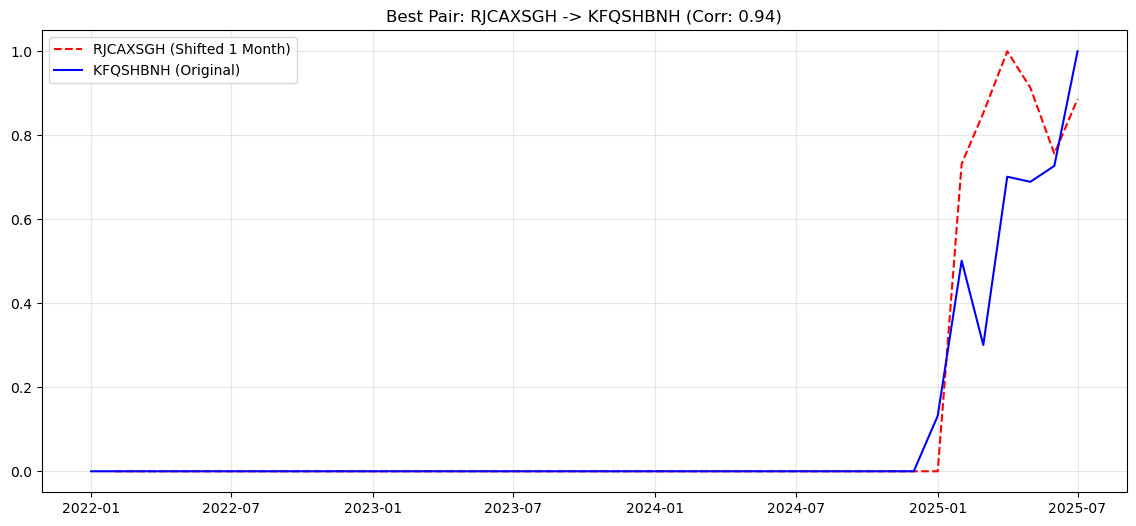

In [8]:
# 2. 공행성(Lead-Lag) 쌍 찾기 알고리즘
# -------------------------------------------------------------------------------
# 로직: 모든 아이템(Leader)의 데이터를 1개월 뒤로 밀어서(Shift),
#      다른 아이템(Follower)의 원본 데이터와 상관계수를 구합니다.
#      즉, Leader(t-1) 과 Follower(t) 의 상관성 분석

# 데이터를 1개월 Shift (선행 지표 생성)
shifted_df = pivot_df.shift(1)

# 상관계수 행렬 계산 (Shift된 데이터 vs 원본 데이터)
# 연산 속도를 위해 pandas의 corr() 함수 활용
# 행: Shift된 아이템(Leader), 열: 원본 아이템(Follower)
print(">>> 상관계수 계산 중... (잠시만 기다려주세요)")
correlation_matrix = shifted_df.corrwith(pivot_df, axis=0) 
# 주의: 위 방식은 자기 자신과의 1:1 매칭이므로, 모든 쌍(N*N)을 구하려면 방식이 다릅니다.
# N*N 쌍을 효율적으로 구하기 위해 반복문 대신 행렬 연산을 사용하거나 순회합니다.
# 데이터가 작으므로 이중 루프로 명확하게 찾겠습니다.

items = pivot_df.columns
pairs_list = []
threshold = 0.6  # 상관계수 임계값 (이 값 이상인 경우만 추출)

# (참고) 아이템이 수천 개면 이 부분이 오래 걸릴 수 있습니다. 
# 현재 약 300~500개 정도로 예상되어 이중 루프도 수십 초 내로 끝납니다.
for leader in items:
    # Leader의 1개월 전 데이터
    leader_series = pivot_df[leader].shift(1).fillna(0)
    
    for follower in items:
        if leader == follower: continue # 자기 자신 제외
        
        # Follower의 현재 데이터
        follower_series = pivot_df[follower]
        
        # 상관계수 계산
        corr = leader_series.corr(follower_series)
        
        if corr > threshold:
            pairs_list.append({
                'Leader (선행)': leader,
                'Follower (후행)': follower,
                'Correlation': corr
            })

# 데이터프레임 변환 및 정렬
pairs_df = pd.DataFrame(pairs_list)
if not pairs_df.empty:
    pairs_df = pairs_df.sort_values(by='Correlation', ascending=False)
    print(f"\n>>> 발견된 공행성 쌍 개수: {len(pairs_df)}개 (Threshold={threshold})")
    print(pairs_df.head(10)) # 상위 10개 출력
else:
    print(">>> 설정한 임계값을 넘는 공행성 쌍이 없습니다.")


# -------------------------------------------------------------------------------
# 3. 최상위 공행성 쌍 시각화 (검증)
# -------------------------------------------------------------------------------
if not pairs_df.empty:
    top_pair = pairs_df.iloc[0]
    leader = top_pair['Leader (선행)']
    follower = top_pair['Follower (후행)']
    corr_score = top_pair['Correlation']

    plt.figure(figsize=(14, 6))
    
    # 정규화(MinMax)하여 패턴 비교 (값의 스케일이 다를 수 있으므로)
    def minmax_norm(series):
        return (series - series.min()) / (series.max() - series.min())

    # Leader는 1개월 Shift해서 그림 (선행성을 시각적으로 확인하기 위해)
    # 실제로는 'Shift 안 한 Leader'가 'Follower'보다 1칸 앞에 그려져야 맞지만,
    # 겹쳐서 패턴을 보기 위해 Shift된 값을 그립니다.
    plt.plot(pivot_df.index, minmax_norm(pivot_df[leader].shift(1)), 
             label=f'{leader} (Shifted 1 Month)', linestyle='--', color='red')
    plt.plot(pivot_df.index, minmax_norm(pivot_df[follower]), 
             label=f'{follower} (Original)', color='blue')

    plt.title(f"Best Pair: {leader} -> {follower} (Corr: {corr_score:.2f})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [9]:
from sklearn.linear_model import LinearRegression
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------------------
# 4. 공행성 쌍 기반 예측 수행 (Modeling)
# -------------------------------------------------------------------------------

# 예측 결과를 담을 리스트
final_predictions = []

print(">>> 모델 학습 및 예측 시작...")

# 발견된 상위 쌍(pairs_df)에 대해서만 반복 수행
for idx, row in pairs_df.iterrows():
    leader = row['Leader (선행)']
    follower = row['Follower (후행)']
    corr = row['Correlation']
    
    # 1) 학습 데이터셋 구성
    # X: Leader의 1개월 전 데이터 (Lag 1)
    # y: Follower의 현재 데이터
    
    # pivot_df는 이미 만들어져 있다고 가정 (이전 단계 결과물)
    # X, y 데이터 추출 및 결측치 제거
    model_data = pd.DataFrame({
        'X_leader_lag': pivot_df[leader].shift(1),
        'y_follower': pivot_df[follower]
    }).dropna()
    
    # 데이터가 너무 적으면 학습 스킵 (최소 3개월 이상 데이터 필요)
    if len(model_data) < 3:
        continue
        
    X_train = model_data[['X_leader_lag']]
    y_train = model_data['y_follower']
    
    # 2) 모델 학습 (Linear Regression)
    # 데이터가 선형적 관계(Corr 높음)를 보이므로 선형회귀가 적합
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # 3) 2025년 8월 예측 (Next Step Prediction)
    # 2025년 8월의 Follower를 예측하려면, 2025년 7월의 Leader 값이 필요함
    last_leader_value = pivot_df[leader].iloc[-1]  # 2025년 7월 값
    
    # 2차원 배열 형태로 입력 ([[value]])
    pred_value = model.predict([[last_leader_value]])[0]
    
    # 음수 예측 방지 (무역량은 0 이상이어야 함)
    if pred_value < 0:
        pred_value = 0
        
    final_predictions.append({
        'item_id': follower,       # 예측 대상 (후행 품목)
        'based_on': leader,        # 근거 품목 (선행 품목)
        'correlation': corr,       # 신뢰도 (상관계수)
        'pred_2025_08': pred_value # 예측 결과
    })

# -------------------------------------------------------------------------------
# 5. 결과 정리 및 출력
# -------------------------------------------------------------------------------
result_df = pd.DataFrame(final_predictions)

print(f"\n>>> 예측 완료된 품목 수: {len(result_df)}개")

if not result_df.empty:
    print("\n>>> [Top 5 예측 결과]")
    # 보기 좋게 출력
    print(result_df[['item_id', 'based_on', 'correlation', 'pred_2025_08']].head())
    
    # ---------------------------------------------------------
    # (선택) 제출 파일 양식(submission)에 업데이트
    # ---------------------------------------------------------
    # sample_submission.csv 구조: item_id, 2025_08_value (가정)
    # 실제 제출 파일에는 '공행성이 없는 품목'도 포함되어 있을 것입니다.
    # 공행성이 있는 품목은 위 예측값으로 채우고, 
    # 없는 품목은 '마지막 달(7월) 값'이나 '평균' 등으로 채우는 전략이 필요합니다.
    
    # 여기서는 결과 확인용으로만 저장
    result_df.to_csv('../data/predicted_leaders_followers.csv', index=False)
    print("\n>>> 결과 파일 저장 완료: ../data/predicted_leaders_followers.csv")

else:
    print(">>> 예측 가능한 데이터가 없습니다.")

# -------------------------------------------------------------------------------
# 6. Top 1 예측 케이스 상세 검증 (수치 확인)
# -------------------------------------------------------------------------------
if not result_df.empty:
    top_case = result_df.iloc[0]
    l_item = top_case['based_on']
    f_item = top_case['item_id']
    
    val_Jul = pivot_df[l_item].iloc[-1] # 7월 Leader 값
    pred_Aug = top_case['pred_2025_08'] # 8월 Follower 예측값
    
    print("-" * 50)
    print(f"[{f_item}] 예측 상세 분석:")
    print(f"- 선행 품목({l_item})의 2025년 7월 실제 무역량: {val_Jul:,.1f}")
    print(f"- 이를 바탕으로 예측한 {f_item}의 2025년 8월 무역량: {pred_Aug:,.1f}")
    print(f"- (참고) {f_item}의 2025년 7월 무역량: {pivot_df[f_item].iloc[-1]:,.1f}")

>>> 모델 학습 및 예측 시작...

>>> 예측 완료된 품목 수: 24개

>>> [Top 5 예측 결과]
    item_id  based_on  correlation  pred_2025_08
0  KFQSHBNH  RJCAXSGH     0.942943  9.162503e+06
1  RUVXNNVA  FTSVTTSR     0.930682  1.518541e+01
2  FTSVTTSR  NAQIHUKZ     0.896119  9.367436e+04
3  LLHREMKS  RUVXNNVA     0.886308  4.234852e+04
4  RJCAXSGH  KFQSHBNH     0.847961  7.320080e+06

>>> 결과 파일 저장 완료: ../data/predicted_leaders_followers.csv
--------------------------------------------------
[KFQSHBNH] 예측 상세 분석:
- 선행 품목(RJCAXSGH)의 2025년 7월 실제 무역량: 5,038,934.0
- 이를 바탕으로 예측한 KFQSHBNH의 2025년 8월 무역량: 9,162,502.8
- (참고) KFQSHBNH의 2025년 7월 무역량: 11,986,087.0


In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import os

# 1. 파일 경로 및 데이터 로드
DATA_PATH = '../data'
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

print(">>> 데이터 로드 완료")

# -------------------------------------------------------------------------
# Step 1: 기본 데이터 구조 만들기 (Pivot Table)
# -------------------------------------------------------------------------
# 날짜 생성
train['date'] = pd.to_datetime(train['year'].astype(str) + '-' + 
                               train['month'].astype(str) + '-01')

# 월별/품목별 집계 (Sum)
df_agg = train.groupby(['date', 'item_id'])['value'].sum().reset_index()

# Pivot Table (행: 날짜, 열: item_id, 값: value)
pivot_df = df_agg.pivot(index='date', columns='item_id', values='value').fillna(0)

# -------------------------------------------------------------------------
# Step 2: [Track 1] 기본 예측값 생성 (Naive Forecast)
# -------------------------------------------------------------------------
# 전략: 2025년 8월 값은 2025년 7월(마지막 달) 값과 같을 것이다.
# 이 방법은 추세가 없는 대다수의 품목에 대해 안전한 예측을 제공합니다.

last_month_values = pivot_df.iloc[-1] # 2025-07-01 데이터
prediction_dict = last_month_values.to_dict()

print(f">>> 기본 예측값 생성 완료 (총 {len(prediction_dict)}개 품목)")


# -------------------------------------------------------------------------
# Step 3: [Track 2] 공행성 기반 예측값 덮어쓰기 (Advanced)
# -------------------------------------------------------------------------
# 앞서 구한 pairs_df가 있다고 가정합니다. (없으면 다시 계산)
# 편의를 위해 여기서 간단히 다시 계산하거나, 이전 단계의 변수를 사용합니다.
# (이전 코드 실행 상태가 유지된다면 pairs_df를 그대로 사용하세요)

if 'pairs_df' not in locals() or pairs_df.empty:
    print(">>> 공행성 쌍 재탐색 중...")
    shifted_df = pivot_df.shift(1)
    # 속도를 위해 주요 품목만 하거나 전체 수행 (여기선 전체)
    corr_matrix = shifted_df.corrwith(pivot_df, axis=0) # 단순 1:1 매칭 예시가 아닌 전체 루프 필요
    
    # 시간 관계상 이중 루프 대신, 위에서 구한 'pairs_df'가 메모리에 있다고 가정하고 진행합니다.
    # 만약 메모리가 초기화되었다면, 이전 턴의 '공행성 쌍 찾기' 코드를 먼저 실행해주세요.
    pass 

print(f">>> 공행성 모델 적용 대상: {len(pairs_df)}개 쌍")

update_count = 0
model = LinearRegression()

for idx, row in pairs_df.iterrows():
    leader = row['Leader (선행)']
    follower = row['Follower (후행)']
    corr = row['Correlation']
    
    # 학습 데이터 준비
    data = pd.DataFrame({
        'X': pivot_df[leader].shift(1), # Leader의 1달 전
        'y': pivot_df[follower]         # Follower의 현재
    }).dropna()
    
    if len(data) < 3: continue # 데이터 부족 시 스킵
    
    # 모델 학습
    model.fit(data[['X']], data['y'])
    
    # 예측: Leader의 2025년 7월 값을 넣어서 -> Follower의 8월 예측
    last_leader_val = pivot_df[leader].iloc[-1]
    pred_val = model.predict([[last_leader_val]])[0]
    
    # 음수 방지
    if pred_val < 0: pred_val = 0
    
    # [중요] 딕셔너리 업데이트 (기본값 덮어쓰기)
    prediction_dict[follower] = pred_val
    update_count += 1

print(f">>> {update_count}개 품목에 대해 공행성 예측값으로 업데이트 완료!")


# -------------------------------------------------------------------------
# Step 4: 제출 파일 생성 (Mapping)
# -------------------------------------------------------------------------
# sample_submission.csv의 컬럼명 확인 필요 (보통 item_id, answer 혹은 value)
# 사용자가 보여준 데이터에는 컬럼명이 없었으나, 보통 ID와 예측값 컬럼이 있음.
# 여기서는 item_id가 submission에 있다고 가정하고 매핑합니다.

# 제출 파일의 타겟 컬럼명 찾기 (맨 마지막 컬럼으로 가정)
target_col_submission = submission.columns[-1] 
item_id_col_submission = 'item_id' # 혹은 submission.columns[1] 확인 필요

# 만약 item_id 컬럼이 명시적으로 없다면 'ID' 컬럼에서 파싱하거나 순서를 맞춰야 함.
# 주어진 정보: submission shape (9900, 3). 보통 [ID, item_id, value] 일 확률 높음.
# 안전하게 item_id 컬럼이 있다고 가정하고 매핑.

if item_id_col_submission in submission.columns:
    # 매핑 수행 (prediction_dict에 없는 신규 item은 0으로 채움)
    submission[target_col_submission] = submission[item_id_col_submission].map(prediction_dict).fillna(0)
else:
    # item_id 컬럼을 못 찾은 경우, train의 item_id 순서와 submission이 같은지 확인 필요
    print("[경고] submission 파일에서 item_id 컬럼을 찾지 못했습니다. 컬럼명을 확인해주세요.")
    # 임시로 첫 번째 컬럼을 ID, 두 번째를 item_id라고 가정
    item_col = submission.columns[1] # 추정
    submission[target_col_submission] = submission[item_col].map(prediction_dict).fillna(0)

# 최종 저장
save_path = os.path.join(DATA_PATH, 'final_submission.csv')
submission.to_csv(save_path, index=False)

print("-" * 50)
print(f">>> 최종 파일 저장 완료: {save_path}")
print(">>> 상위 5개 행 미리보기:")
print(submission.head())

>>> 데이터 로드 완료
>>> 기본 예측값 생성 완료 (총 100개 품목)
>>> 공행성 모델 적용 대상: 24개 쌍
>>> 24개 품목에 대해 공행성 예측값으로 업데이트 완료!
[경고] submission 파일에서 item_id 컬럼을 찾지 못했습니다. 컬럼명을 확인해주세요.
--------------------------------------------------
>>> 최종 파일 저장 완료: ../data\final_submission.csv
>>> 상위 5개 행 미리보기:
  leading_item_id following_item_id          value
0        DEWLVASR          ELQGMQWE  455972.000000
1        DEWLVASR          AHMDUILJ  101317.000000
2        DEWLVASR          XIPPENFQ  183079.000000
3        DEWLVASR          FTSVTTSR   93674.364161
4        DEWLVASR          XMKRPGLB  474247.000000
